# Chaos during a stampede

Authors: Ward van Belle, Bram Spanoghe

Based on the following paper (Jiaxuan Yi et al., 2020): https://www.sciencedirect.com/science/article/pii/S1569190X20300861?casa_token=eoCj844--UoAAAAA%3AW5IEQVZQbP5ILasesMnahd3iIgfHNXfAWnaI7RsboLHrfqNA-UNxb_pyNF5FIyDN0hoKbjdC-EA 

### Steps:
1. Populate board with random amount of people in random positions
2. In each time step, calculate the static floor field Sij, the dynamic floor field Dij and the event floor field Fij with help of the formulas.
3. For each pedestrian, determine his/her state and make a decision regarding movement behavior. If the pedestrian is in
state Ue,Un or Ae, calculate the transition probability according to Eqs. (15)–(17), respectively. If the pedestrian is in state An, he/
she chooses one of the strategies S1, S2 or S3 to evacuate. If the pedestrian is in state C, calculate the probability of him/her
getting up again.
4. Each pedestrian moves to his/her target cell. If the pedestrian chooses a target cell that is occupied by a fallen pedestrian, he/she will be tripped and become a new fallen pedestrian.
5. If the chaos duration is over, uninjured pedestrians regard fallen pedestrians as obstacles and conduct a normal evacuation. There will be no more new fallen pedestrians.
6. When multiple pedestrians choose to move to the same target, one pedestrian is randomly selected with equal probability to move to the target cell, and other pedestrians remain in their original cells.
7. Determine whether the evacuation is over. If there are still uninjured pedestrians in the room, return to step 2 and repeat the simulation process until all the uninjured pedestrians evacuate from the room.

### Variables:

S = static floor: describes pedestrian behavior of finding the shortest path to the exit during the evacuation process.
D = dynamic floor: represents the interactions among pedestrians in the evacuation process.
F = event floor: reflects thhat some pedestrians intend to escape from the stampede location when they are affected by the stampede.
A = risk floor field: depicts that pedestrian movement direction affects the risk of being tripped.

### evac strategies:
S1 = Tries to stay away from the stampede location (Eq 1)
S2 = Follows movement of neighbours 
S3 = keeps moving in same direction until wall is reached, then follows it clockwise or anti clockwise.
     when they stay in the same cell for more then 5 time steps, they change the desired direction randomly.


# Imports

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import warnings

In [2]:
# Comment to show warnings
warnings.filterwarnings('ignore') # There are some overflow warnings inherent to the model, which is why we suppress warnings

# Functions

In [3]:
def make_gif(frames, filename = None, FPS = 10):
    """
    Makes a gif.    
    Parameters
    ----------
    frames : numpy array
        3D numpy arrays of videoframes (time is first dimension)
    filename : str, optional
        If a filename is given, a gif is saved from the video. The default is None."""
    
    # Adapted from the great gods of Spatio-Temporal Models

    print("\nMaking a gif...")
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    im = ax.imshow(frames[0, :, :])
    
    def update_img(n):
        im.set_data(frames[n, :, :])
        return ax
    
    ani = animation.FuncAnimation(fig,update_img, frames.shape[0])
    if isinstance(filename, str):
        if filename[-4:] != ".gif":
            filename += ".gif" 
    else: 
        filename = "goudvis.gif"
    ani.save(filename,writer='pillow',fps=FPS, dpi=100)
    print("Gif saved as "+ filename)

def init_board(board_size,num_people,exit_locs,sight_radius,state_dic, B_exit, B_wall):
    """Creates board with size r x r and populates it with num_people people
    """

    # create board with all walls being 500
    board = np.ones((board_size,board_size), dtype = "int") * B_wall
    board[1:-1,1:-1] = 0

    # add the exit locations
    board[exit_locs] = B_exit

    # calculate all possible locations
    locations = [[y,x] for x in range(1,board_size-1) for y in range(1,board_size-1)]

    if len(locations) >= num_people:
        uniq_locations = random.sample(locations,num_people)
    else:
        raise ValueError('num_people can not be greater than the number of free spaces on the board')

    # add the people to the board
    person_list = []

    exits = [[exit_locs[0][i], exit_locs[1][i]] for i in range(len(exit_locs[0]))]

    for i,location in enumerate(uniq_locations):
        # set standard state to 'Un' if exit in range set to 'Ue'
        pstate = 'Un'
        for exit_loc in exits:
            if np.sqrt((exit_loc[0]-location[0])**2+(exit_loc[1]-location[1])**2) <= sight_radius:
                pstate = 'Ue'
        
        person_list.append(Pedestrian(location,pstate))

        board[location[0], location[1]] = state_dic[pstate]

    return board, np.array(person_list)

def update_board(board_size,person_list,state_dic,chaos,B_exit):
    """Updates the given board based on the given person_list
    """

    board = np.ones((board_size,board_size), dtype = "int") * B_wall
    board[1:-1,1:-1] = 0

    # add the exit locations
    board[exit_locs] = B_exit

    for person in person_list:
        if person.state != 'C':
            board[person.location[0], person.location[1]] = state_dic[person.state]
        elif chaos:
            board[person.location[0], person.location[1]] += state_dic[person.state]
            board[person.new_location[0], person.new_location[1]] += state_dic[person.state]
        else:
            board[person.location[0], person.location[1]] = -1
            board[person.new_location[0], person.new_location[1]] = -1
    
    fallen_locs = np.where(board > 0)
    board[exit_locs] = B_exit

    return fallen_locs, board

def get_locations(person_list):
    """Create a (num_people,) sized array with all locations of everyone in the given person_list
    """
    return np.array([person.location for person in person_list])

def get_directions(board_size,person_list):
    """Create a (board_size, board_size) sized array filled with directions of people on that place on the board
    """
    directionmap = np.ones((board_size,board_size,2))*2 # we use [2,2] for empty cells since [0,0] is equal to standing still
    for person in person_list:
        directionmap[person.location[0],person.location[1],:] = person.direction

    return directionmap

def get_perceptionmask(sight_radius):
    """Creates a boolean mask selecting all cells within perception range of a person.
    This mask is to be applied on a 2*sight_radius+1 x 2*sight_radius+1 grid with the person in question in the middle.
    """
    mask = np.zeros((2*sight_radius+1, 2*sight_radius+1), dtype = "bool")
    y_m, x_m = sight_radius, sight_radius # Coordinates of midpoints
    perceived_cells = [[y, x] for y in range(2*sight_radius+1) for x in range(2*sight_radius+1) if (y-y_m)**2 + (x-x_m)**2 <= sight_radius**2]
    perceived_cells = ([cell[0] for cell in perceived_cells], [cell[1] for cell in perceived_cells])
    mask[perceived_cells] = True
    mask[y_m, x_m] = False # Don't select the cell itself (middle cell)
    return mask


def init_S(board_size, S_wall, S_exit, obstacle_locs, exit_locs, mu):
    """Creates the initial static floor field S.
    The static floor field describes the path on the grid which is the shortest way to the exit.
    All walls are assumed to be on the outside of the grid.
    """
    S = np.ones((board_size, board_size)) * np.inf # Initialise array full of +infinity since filling up S is based on selecting minimum values
    side_neighbour_mask = np.zeros((3, 3), dtype = bool)
    side_neighbour_mask[0, 1] = side_neighbour_mask[1, 0] = side_neighbour_mask[1, -1] = side_neighbour_mask[-1, 1] = True

    diag_neighbour_mask = np.zeros((3,3), dtype = bool)
    diag_neighbour_mask[0, 0] = diag_neighbour_mask[0, -1] = diag_neighbour_mask[-1, 0] = diag_neighbour_mask[-1, -1] = True

    S[exit_locs] = S_exit
    if obstacle_locs: # => If the list of obstacles isn't empty
        S[tuple(obstacle_locs)] = np.inf


    curr_cells = [[exit_locs[0][i], exit_locs[1][i]] for i in range(len(exit_locs[0]))]
    next_cells = []
    done_cells = []
    paired_obstacle_locs = [[obstacle_locs[0][i], obstacle_locs[1][i]] for i in range(len(obstacle_locs[0]))]


    # The exit cells are the only cells on the border to evaluate and require a special treatment (don't select any cells outside of the existing grid)
    for y, x in curr_cells:
        for i in np.arange(np.maximum(1, y-1), np.minimum(board_size-1, y+2)):
            for j in np.arange(np.maximum(1, x-1), np.minimum(board_size-1, x+2)):
                if (i, j) != (y, x) and not [i, j] in paired_obstacle_locs:
                    if ((y-i)+(x-j))%2 == 0: # diagonal neighbour
                        S[i,j] = np.minimum(S[y, x] + mu, S[i, j])
                    else: # side neighbour
                        S[i,j] = np.minimum(S[y, x] + 1, S[i, j])

                    next_cells += [[i, j]]

                    S[:, 0] = S[:, -1] = np.inf
                    S[0, :] = S[-1, :] = np.inf
                    S[exit_locs] = S_exit
                    if obstacle_locs: # => If the list of obstacles isn't empty
                        S[tuple(obstacle_locs)] = np.inf

    while next_cells:
        done_cells += curr_cells
        curr_cells = next_cells
        next_cells = []

        for y, x in curr_cells:
            S[y-1:y+2, x-1:x+2][side_neighbour_mask] = np.minimum(S[y, x] + 1, S[y-1:y+2, x-1:x+2][side_neighbour_mask])
            S[y-1:y+2, x-1:x+2][diag_neighbour_mask] = np.minimum(S[y, x] + mu, S[y-1:y+2, x-1:x+2][diag_neighbour_mask])
            next_cells += [[y+i, x+j] for i in range(-1, 2) for j in range(-1, 2) if i != 0 or j != 0 if y+i > 0 and y+i < board_size-1 if x+j > 0 and x+j < board_size-1] # Select all neighbouring cells but not the cell itself
            next_cells = [next_cell for next_cell in next_cells if not next_cell in paired_obstacle_locs] # You don't have to go over obstacles
            S[:, 0] = S[:, -1] = np.inf
            S[0, :] = S[-1, :] = np.inf
            
            S[exit_locs] = S_exit
            if obstacle_locs: # => If the list of obstacles isn't empty
                S[tuple(obstacle_locs)] = np.inf
            
        next_cells = np.unique(next_cells, axis = 0).tolist() # Specify axis or the list of lists will be flattened to 1 list
        next_cells = [cell for cell in next_cells if not cell in done_cells]

    S[S != np.inf] = np.amax(S[S != np.inf]) - S[S != np.inf]

    S[S == np.inf] = S_wall

    return S

def init_D(board_size):
    """Creates the initial dynamic floor field D.
    The dynamic floor field describes interactions between pedestrians 
    (i.e. people don't tend to intentionally sprint into eachother when trying to evacuate)
    """
    D = np.zeros((board_size, board_size))

    return D

def update_D(D, locations, locations_prev, diffusion_factor, decay_factor):
    """Updates the dynamic floor field D.
    """
    neighbour_mask = np.ones((3, 3), dtype = bool)
    neighbour_mask[1, 1] = False

    D_new = np.copy(D)
    for i in range(1, D.shape[0]-1):
        for j in range(1, D.shape[1]-1):
            D_new[i, j] = (1-diffusion_factor)*(1-decay_factor)*D[i, j] + diffusion_factor*(1-decay_factor)/8 * np.sum(D[i-1:i+2, j-1:j+2][neighbour_mask])

    updated_locations = locations[np.any(locations_prev != locations,axis=1)]
    D_new[updated_locations[:,0], updated_locations[:,1]] += 1
    
    return D_new

def create_dist_mat(board_size, obstacle_locs):
    """Creates a distance matrix
    The distance matrix shows the minimum distance to any of the given obstacles for every place on the board.
    """
    obstacle_dist = np.zeros((0,board_size,board_size))

    # initialize the x and y values of the board

    x = y = np.arange(board_size)
    x = np.reshape(x,(1,board_size))
    x = np.matmul(np.ones((board_size,1)),x)
    y = np.reshape(y,(board_size,1))
    y = np.matmul(y,np.ones((1,board_size)))

    if len(obstacle_locs[0]) > 0: # There are obstacles
        # for every obstacle calculate the distance to every point on the board

        for i in range(len(obstacle_locs[0])):
            dist_mat = np.sqrt(np.square(y - obstacle_locs[0][i]) + np.square(x - obstacle_locs[1][i]))
            dist_mat = np.reshape(dist_mat,(1,board_size,board_size))
            obstacle_dist = np.vstack((obstacle_dist,dist_mat))

        # take the minimal distance to an obstacle for every point on the board

        min_dist_mat = np.amin(obstacle_dist,axis=0)
    else: # There are no obstacles
        min_dist_mat = np.zeros((board_size, board_size))

    return min_dist_mat

def init_F(board_size):
    """Creates the event floor field F.
    The event floor field describes the efect that a person wants to get away from the stampede.
    """
    
    F = np.zeros((board_size, board_size))
    
    return F 

def update_F(board_size, obstacle_locs, Srange):
    """Updates the event floor field F.
    """
    
    F = create_dist_mat(board_size, obstacle_locs)

    # give correct values to every point on the board
    F[F <= Srange] = -1*np.exp(1/F[F <= Srange])
    F[F > Srange] = 0
    
    return F 

def calc_tumble(person,sight_radius,ka,kc,board,new_loc):
    """This function calculates the tumble factor for the move from a persons current position to
    Their next position given as [x,y] by new_loc
    """
    
    if not (board[new_loc[0], new_loc[1]] >= 1).all(): # 1+ means there are 1 or more fallen people in the desired cell
        return 1
    else:
        y_person = person.location[0]
        x_person = person.location[1]

        # Only select cells within grid and not on the border (these are walls)
        y_min = max(1, y_person-sight_radius)
        y_max = min(board_size-1, y_person+sight_radius+1)
        x_min = max(1, x_person-sight_radius)
        x_max = min(board_size-1, x_person+sight_radius+1)
        neighbouring_cells = board[y_min:y_max, x_min:x_max]

        # Only select part of mask that applies to selected cells (if you cut off some cells, the same part of the mask must be cut off)
        y_min_mask = y_min - (y_person-sight_radius)
        y_max_mask = y_max - (y_person-sight_radius)
        x_min_mask = x_min - (x_person-sight_radius)
        x_max_mask = x_max - (x_person-sight_radius)
        perceptionmask = get_perceptionmask(sight_radius)[y_min_mask:y_max_mask, x_min_mask:x_max_mask]
        perceived_cells = neighbouring_cells[perceptionmask]

        # perceived_cells that are not 0, -1, -2: other pedestrians
        rho_0 = (perceived_cells[perceived_cells <= -3].size + perceived_cells[perceived_cells >= 1].size) / perceived_cells.size 

        if rho_0 >= 0.64: # more then 4 people/m^2 so trample threshold is exceeded
            eps = 1
        else:
            eps = 0

        # theta is de hoek tussen bewegingsrichting van vorige stap en normaal van huidige cell naar cell ij (in het bereik van 0 en 180 graden)
        theta = np.arccos(np.dot(np.array(person.direction), np.array([new_loc[i] - person.location[i] for i in range(len(new_loc))]))) % (np.pi) 
        # Assuming directions input as lists rather than numpy arrays
        A = np.cos(theta) - 1 # Risk floor field A

        alpha = kc*eps*rho_0*np.exp(ka*A)

        return alpha


def check_state(person,exit_locs,fallen_locs,chaos):
    """Updates the state of a given person
    """
    
    if person.state != "C":
        if person.state == "Ue" or person.state == "Un" or not chaos:

            exits = [[exit_locs[0][i], exit_locs[1][i]] for i in range(len(exit_locs[0]))]

            # set standard state to 'Un' if exit in range set to 'Ue'

            pstate = 'Un'

            if person.location in exits:
                pstate = 'left'
            else:
                for exit_loc in exits:
                    if np.sqrt((exit_loc[0]-person.location[0])**2+(exit_loc[1]-person.location[1])**2) <= sight_radius:
                        pstate = 'Ue'
            
            # check if affected and state accordingly
            if pstate != 'left' and len(fallen_locs[0]) != 0: # Only have to check for fallen pedestrians in the neighbourhood if there are any
                affected = create_dist_mat(board_size, fallen_locs)
                affected[affected <= 8] = True
                affected[affected > 8] = False

                if affected[person.location[0], person.location[1]]:
                    if pstate == 'Un':
                        pstate = 'An'
                    elif pstate == 'Ue':
                        pstate = 'Ae'

        elif chaos: # So it's An or Ae

            exits = [[exit_locs[0][i], exit_locs[1][i]] for i in range(len(exit_locs[0]))]

            pstate = 'An'

            if person.location in exits:
                pstate = 'left'
            else:
                for exit_loc in exits:
                    if np.sqrt((exit_loc[0]-person.location[0])**2+(exit_loc[1]-person.location[1])**2) <= sight_radius:
                        pstate = 'Ae'

        person.state = pstate

    return person

def check_valid4wallhugger(board, location):
    """Checks if a given location on the board is a valid place for someone who wants to stay next to walls to go to (strategy S3).
    """
    y = location[0]
    x = location[1]

    if board[y, x] != 0:
        return False

    neighbour_mask = np.ones((3, 3), dtype = bool)
    neighbour_mask[1, 1] = False

    return -1 in board[y-1:y+2, x-1:x+2][neighbour_mask]

def move_direction(person,person_list,board,S,D,F,exit_locs,fallen_locs,paired_fallen_locs,directionmap,sight_radius,board_size,ks,kd,kf,ka,kc,B_wall,B_exit,state_dic):
    """Updates the desired location (new_location) of a given person.
    This function looks at the current state of the person based on this state it defines it next movement step.
    Then it defines the chance of this step being taken and lastly it chooses the step with the highest probability and takes it.
    """

    possible_moves = [[y,x] for y in range(-1,2) for x in range(-1,2)]

    if person.state == "C":
            if person.time_down < 100: # Prevent factorial from causing an Overflow error
                pstand = 1/(np.exp(1)*np.math.factorial(person.time_down))
                person.time_down += 1
            else:
                pstand = 0
                
            if np.random.rand() <= pstand:
                person.state = 'Ue'
                person = check_state(person,exit_locs,fallen_locs,chaos)
                person.time_down = 0

                random_dir_ind = np.random.randint(len(possible_moves)) # Choose yourself a fun new favorite direction when you get up (in case you have the S3 strat)
                person.direction = possible_moves[random_dir_ind]

                if board[person.location[0], person.location[1]] >= 1:
                    board[person.location[0], person.location[1]] -= 1
                else:
                    board[person.location[0], person.location[1]] = state_dic[person.state]
                if board[person.new_location[0], person.new_location[1]] >= 1:
                    board[person.new_location[0], person.new_location[1]] -= 1
                else:
                    board[person.location[0], person.location[1]] = 0

                if board[person.location[0], person.location[1]] <= 1:
                    paired_fallen_locs = [loc for loc in paired_fallen_locs if loc != person.location] # If this person was the only one on the ground there, remove this location from the obstacle list
    
    if person.state != "C": # No "else" because someone who just got up has freshly become a != "C" and is allowed to chose a move
        y = person.location[0]
        x = person.location[1]
        pmove = np.zeros((3,3))

        if person.state == 'Ue':
            for i in range(y-1,y+2):
                for j in range(x-1,x+2):
                    if [i,j] != [y,x]:
                        if np.all(np.array([y,x])-np.array([i,j]) == person.direction):
                            Iine = 1.2
                        else:
                            Iine = 1

                        pmove[i-(y-1),j-(x-1)] = Iine*np.exp(ks*S[i,j])*(board[i,j] >= B_exit)*(board[i,j] != B_wall)

                    else:
                        pmove[i-(y-1),j-(x-1)] = 0
            
            pmove[np.isnan(pmove)] = 0
            if np.sum(pmove) == 0: # No legal movements available
                pmove[1,1] = 1 # Standing still is the only legal movement
            elif np.sum(pmove) == np.inf:
                pmove[np.logical_not(np.isinf(pmove))] = 0
                pmove[np.isinf(pmove)] = 1
            pmove = pmove / np.sum(pmove)
            move = possible_moves[np.random.choice(range(9), 1, p = pmove.flatten())[0]] # note: this gives a list in the format of [y_move,x_move]

        elif person.state == 'Un':
            for i in range(y-1,y+2):
                for j in range(x-1,x+2):
                    if [i,j] != [y,x]:
                        if np.all(np.array([y,x])-np.array([i,j]) == person.direction):
                            Iine = 1.2
                        else:
                            Iine = 1
                        pmove[i-(y-1),j-(x-1)] = Iine*np.exp(ks*S[i,j] + kd*D[i,j])*(board[i,j] >= B_exit)*(board[i,j] != B_wall)                            
                    else:
                        pmove[i-(y-1),j-(x-1)] = 0
            
            pmove[np.isnan(pmove)] = 0
            if np.sum(pmove) == 0: # No legal movements available
                pmove[1,1] = 1 # Standing still is the only legal movement
            elif np.sum(pmove) == np.inf:
                pmove[np.logical_not(np.isinf(pmove))] = 0
                pmove[np.isinf(pmove)] = 1
            pmove = pmove / np.sum(pmove)
            move = possible_moves[np.random.choice(range(9), 1, p = pmove.flatten())[0]] # note: this gives a list in the format of [y_move,x_move]

        elif person.state == 'Ae':
            for i in range(y-1,y+2):
                for j in range(x-1,x+2):
                    if [i,j] != [y,x]:
                        if np.all(np.array([y,x])-np.array([i,j]) == person.direction):
                            Iine = 1.2
                        else:
                            Iine = 1
                        alphaij = calc_tumble(person,sight_radius,ka,kc,board,[i,j])
                        pmove[i-(y-1),j-(x-1)] = Iine*np.exp(ks*S[i,j])*(board[i,j] >= B_exit)*(board[i,j] != B_wall)*alphaij

                    else:
                        pmove[i-(y-1),j-(x-1)] = 0
            
            pmove[np.isnan(pmove)] = 0
            if np.sum(pmove) == 0: # No legal movements available
                pmove[1,1] = 1 # Standing still is the only legal movement
            elif np.sum(pmove) == np.inf:
                pmove[np.logical_not(np.isinf(pmove))] = 0
                pmove[np.isinf(pmove)] = 1
            pmove = pmove / np.sum(pmove)
            move = possible_moves[np.random.choice(range(9), 1, p = pmove.flatten())[0]] # note: this gives a list in the format of [y_move,x_move]

        elif person.state == 'An':
            if person.evac_strat == 'S1':
                for i in range(y-1,y+2):
                    for j in range(x-1,x+2):
                        if [i,j] != [y,x]:
                            if np.all(np.array([y,x])-np.array([i,j]) == person.direction):
                                Iine = 1.2
                            else:
                                Iine = 1
                            alphaij = calc_tumble(person,sight_radius,ka,kc,board,[i,j])
                            pmove[i-(y-1),j-(x-1)] = Iine*np.exp(ks*S[i,j] + kd*D[i,j] + kf*F[i,j])*(board[i,j] >= B_exit)*(board[i,j] != B_wall)*alphaij
                        else:
                            pmove[i-(y-1),j-(x-1)] = 0

                pmove[np.isnan(pmove)] = 0
                if np.sum(pmove) == 0: # No legal movements available
                    pmove[1,1] = 1 # Standing still is the only legal movement
                elif np.sum(pmove) == np.inf:
                    pmove[np.logical_not(np.isinf(pmove))] = 0
                    pmove[np.isinf(pmove)] = 1
                pmove = pmove / np.sum(pmove)
                move = possible_moves[np.random.choice(range(9), 1, p = pmove.flatten())[0]] # note: this gives a list in the format of [y_move,x_move]

            elif person.evac_strat == 'S2':
                dist_mat = create_dist_mat(board_size, ([person.location[0]],[person.location[1]]))
                dist_mat = (dist_mat <= sight_radius)

                neighbour_directions = directionmap[dist_mat]
                # Filter out stand still and do nothing
                neighbour_directions = np.array([direction for direction in neighbour_directions if not np.all(direction == [2,2])])
                if neighbour_directions.size == 0 or person.time_down >= 5: # No non-fallen people in sight or has been standing still for too long, choose a random move
                    valid_cells = np.where(board[y-1:y+2, x-1:x+2] == 0)
                    if valid_cells[0].size == 0: # There is no valid location to go
                        move = [0, 0]
                    else:
                        valid_directions = [[valid_cells[0][i] - 1, valid_cells[1][i] - 1] for i in range(len(valid_cells[0]))]
                        ## -1, -1 since movement is related to position of the person in cell [1,1] in their own neighbourhood

                        random_dir_ind = np.random.randint(len(valid_directions))
                        move = valid_directions[random_dir_ind]
                else:
                    unq, count = np.unique(neighbour_directions, axis=0, return_counts=True)
                    ind = np.argsort(-count)[0]
                    move = [int(x) for x in unq[ind]]

                if board[y+move[0],x+move[1]] == B_wall:
                    move = [0, 0] # maybe change to strategy S3
                
                if move == [0, 0]:
                    person.time_down += 1
                else:
                    person.time_down = 0

            else:
                if person.direction == [0,0]: # Standing still
                    person.time_down += 1
                if person.time_down >= 5: # They have been standing still for a while so they choose a random new direction
                    valid_cells = np.where(board[y-1:y+2, x-1:x+2] == 0) # Choose from locations without other people for the new direction
                    if valid_cells[0].size == 0: # There is no valid location to go
                        move = [0, 0]
                    else:
                        valid_directions = [[valid_cells[0][i] - 1, valid_cells[1][i] - 1] for i in range(len(valid_cells[0]))]
                        ## -1, -1 since movement is related to position of the person in cell [1,1] in their own neighbourhood

                        random_dir_ind = np.random.randint(len(valid_directions))
                        move = valid_directions[random_dir_ind]
                        person.time_down = 0
                elif board[y + person.direction[0], x + person.direction[1]] == -1: # wall is reached
                    mask = np.array([check_valid4wallhugger(board, [i, j]) for i in range(y-1,y+2) for j in range(x-1,x+2)]).reshape(3,3)
                    mask[1,1] = True # Current location is always a valid spot despite it not being empty (the person themselves are there)
                    valid_cells = np.where(mask)
                    ideal_cell_ind = np.argmax(S[y-1:y+2, x-1:x+2][valid_cells])
                    move = [valid_cells[0][ideal_cell_ind]-1, valid_cells[1][ideal_cell_ind]-1]
                else:
                    move = person.direction
        elif person.state == "left": # Very rare but can happen if they fell down in the doorway! :D
            move = [0,0]

        person.direction = move
        person.new_location = [y + move[0], x + move[1]]

        if person.new_location in paired_fallen_locs: # Fallen person on the location they are moving, so they trip
            person.state = "C"
            person.time_down = 0
            person.direction = [2,2]
            if board[person.location[0], person.location[1]] <= 0:
                board[person.location[0], person.location[1]] = 1 # Person themselves were on the location, so don't +1 but set to 1
            else:
                board[person.location[0], person.location[1]] += 1 # There was a fallen person on location, so +1

            board[person.new_location[0], person.new_location[1]] += 1 # There was a fallen person on new_location, so +1

    return person, board

def check_stampede(people_list,chaos):
    """Checks if the stampede is still ongoing.
    """
    states = np.array([person.state for person in people_list])

    if np.all(states == 'left') or len(states) == 0: # everybody evacuated
        stampede = False
    elif np.all((states == 'left') + (states == 'C')) and not(chaos): # all non injured people left and chaos is over
        stampede = False
    else:
        stampede = True
    
    return stampede

def plot_room(board,state_dic,B_exit,B_wall):
    """Turns the board into a more suitable image for visualisation.
    """
    color_map = {0: np.array([1, 1, 1]), # white = empty floor
             B_exit: np.array([1, 0, 1]), # white = exits
             state_dic['Ue']: np.array([0, 1, 0]), # green = Ue
             state_dic['Un']: np.array([0, 0, 1]), # blue = Un
             state_dic['Ae']: np.array([0, 1, 1]), # cyan = Ae
             state_dic['An']: np.array([1, 1, 0]), # yellow = An
             state_dic['C']: np.array([1, 0, 0]), # red = C
             B_wall: np.array([0, 0, 0])} # black = walls

    # make a 3d numpy array that has a color channel dimension   
    data_3d = np.ndarray(shape=(board.shape[0], board.shape[1], 3), dtype=float)
    for i in range(board.shape[0]):
        for j in range(board.shape[1]):
            if int(board[i,j]) > 1:
                data_3d[i,j] = np.array([(1/board[i,j])**0.5, 0, 0])
            else:
                data_3d[i,j] = color_map[int(board[i,j])]
    
    return data_3d


# classes

class Pedestrian:
  def __init__(self, location, state):
    self.evac_strat = random.choices(['S1','S2','S3'],(50,30,20))[0]
    self.location = location # gives location as [y,x]
    self.state = state 
    self.direction = [0,0] # showes the last direction moved eg. [1,0] is left and [0,-1] is down
    self.new_location = location
    self.time_down = 0

# Standard parameters

In [4]:
board_size = 30 # size of board 
num_people = 300 # number of people

exit_locs = ([int(board_size/2-2), int(board_size/2-1), int(board_size/2), int(board_size/2+1)], [0, 0, 0, 0]) # exit locations (middle of left wall)
obstacle_locs = [[],[]]
fallen_locs = [[],[]] # No obstacles for now

S_wall = 500 # 500 in the article but we're smarter
S_exit = 1
B_wall = -1
B_exit = -2
mu = 1.5

Ts = 30 # occurrence time of the stampede
Tc = Ts + 30 # chaos ending time

kc = 0.5 # sensitivity parameter for tumble factor 
ka = 1 # sensitivity parameter for tumble factor 
ks = 5 # sensitivity parameter for the static field
kd = 1 # sensitivity parameter for the dynamic field
kf = 2 # sensitivity parameter for the event field
diffusion_factor = 0.3 # aka alpha
decay_factor = 0.3 # aka delta
sight_radius = 5 # perception radius for each person

Srange = 8 # stampede range

state_dic = {'C':1,'left':0,'Ue':-3,'Un':-4,'Ae':-5,'An':-6}

# Do a full evacuation simulation

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
The stampede lasted 115 seconds.

Making a gif...
Gif saved as stampede.gif


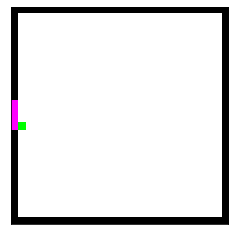

In [5]:
# main function

# fill board with people and initialize them

board, person_list = init_board(board_size,num_people,exit_locs,sight_radius,state_dic,B_exit,B_wall)
initial_fall_locs = [[16, 4]]
initial_fall_loc = initial_fall_locs[np.random.randint(len(initial_fall_locs))]

# add starting board to stampede clip, this will later be transformed to a gif.

stampede_clip = np.zeros((0,board_size,board_size,3))
temp = np.reshape(plot_room(board,state_dic,B_exit,B_wall),(1,board_size,board_size,3))
stampede_clip = np.vstack((stampede_clip,temp))

time = 0
endtime = 200

stampede = True
chaos = False

S = init_S(board_size, S_wall, S_exit, obstacle_locs, exit_locs, mu)
D = init_D(board_size)
F = init_F(board_size)

while stampede and time <= endtime:
    print(time)

    if time == Ts:
        chaos = True
        c_list = np.random.choice(range(len(person_list)), size=(1), replace = False)
        for x in c_list:
            person_in_the_way = [person for person in person_list if person.location == initial_fall_loc]
            if len(person_in_the_way) > 0:
                person_in_the_way[0].location = person_list[x].location

            person_list[x].state = 'C'
            person_list[x].time_down = 0 
            person_list[x].direction = [2,2]
            person_list[x].location = initial_fall_loc
            person_list[x].new_location = person_list[x].location
            c_loc = person_list[x].location
            board[c_loc[0],c_loc[1]] = 2*state_dic['C']

        fallen_locs,board = update_board(board_size,person_list,state_dic,chaos,B_exit)
        F = update_F(board_size, fallen_locs, Srange)

    if time > Tc and chaos:
        chaos = False
        obstacle_locs[0] += list(fallen_locs[0])
        obstacle_locs[1] += list(fallen_locs[1])
        S = init_S(board_size, S_wall, S_exit, obstacle_locs, exit_locs, mu)

    # step 2: iterate over every person in person_list

    if time > 1 and len(prev_locations) > 0:
        D = update_D(D, locations, prev_locations, diffusion_factor, decay_factor)

    if time > 1 and not(np.array_equal(fallen_locs,prev_fallen_locs)) and len(fallen_locs[0]) > 0:
        # note that Fij is -inf if there is an obstacle/fallen person on Fij
        F = update_F(board_size, fallen_locs, Srange)

    prev_fallen_locs = fallen_locs
    prev_locations = get_locations(person_list)
    directionmap = get_directions(board_size,person_list)
    paired_fallen_locs = [[fallen_locs[0][i], fallen_locs[1][i]] for i in range(len(fallen_locs[0]))]

    for person in person_list:
        
        # calculate state of person
        person = check_state(person,exit_locs,fallen_locs,chaos)
        
        # if person has been evacuated, remove from person list

        if person.state == 'left':
            person_id = person_list == person
            person_list = np.delete(person_list, person_id)
            prev_locations = np.delete(prev_locations,person_id,axis=0)
            locations = np.delete(locations,person_id,axis=0)

        else:
            # calculate movement of each person 
            # or if person.state = 'C' calculate chance of getting up
            
            person, board = move_direction(person,person_list,board,S,D,F,exit_locs,fallen_locs,paired_fallen_locs,directionmap,sight_radius,board_size,ks,kd,kf,ka,kc,B_wall,B_exit,state_dic)
            fallen_locs, board = update_board(board_size,person_list,state_dic,chaos,B_exit)
            paired_fallen_locs = [[fallen_locs[0][i], fallen_locs[1][i]] for i in range(len(fallen_locs[0]))]
    
    next_locations = np.array([person.new_location for person in person_list if person.state != 'C'])
    next_loc_person_list = np.array([person for person in person_list if person.state != 'C'])

    # find duplicate locations in next_locations list and put in dupes

    dupes, count = np.unique(next_locations, axis=0, return_counts=True)
    non_dupes = dupes[count == 1]
    dupes = dupes[count > 1]
    if dupes.size > 0:

        for dupe in dupes:
            # for all dupes calc which person moves and set its location to new location
            # The other persons stay in their original location and thus don't need to be adjusted
            people_moving = next_loc_person_list[np.all(next_locations == dupe,axis=1)]
            np.random.shuffle(people_moving)
            picked = people_moving[0]
            picked.location = picked.new_location
            people_moving = people_moving[1:]
            
            for people in people_moving:
                if people.new_location in paired_fallen_locs:
                    people.new_location = people.location
                    person.state = "C"
                    person.time_down = 0
                    person.direction = [2,2]
                    board[person.location[0], person.location[1]] += 1
                    board[person.new_location[0], person.new_location[1]] += 1

        
        for non_dupe in non_dupes:
            # set location to new locations
            person_moving = next_loc_person_list[np.all(next_locations == non_dupe,axis=1)][0]
            person_moving.location = person_moving.new_location
    
    else:
        for person in next_loc_person_list:
            person.location = person.new_location

    locations = get_locations(person_list)

    # check if stampede is over

    stampede = check_stampede(person_list,chaos)

    # write current board to total
    temp = np.reshape(plot_room(board,state_dic,B_exit,B_wall),(1,board_size,board_size,3))
    stampede_clip = np.vstack((stampede_clip,temp))
        
    time += 1
print(f"The stampede lasted {time-1} seconds.")
make_gif(stampede_clip, filename = 'stampede')

# Recreate fig. 8

0


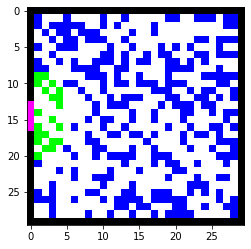

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


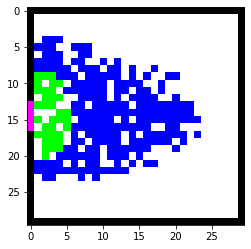

21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


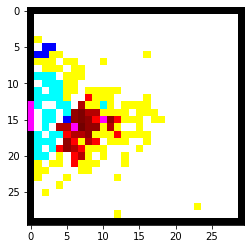

41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


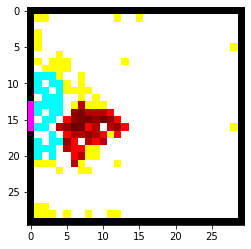

61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


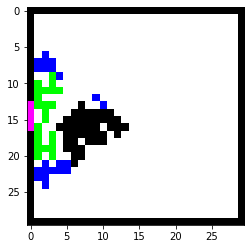

81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
The stampede lasted 99 seconds.

Making a gif...
Gif saved as stampede_fig8.gif


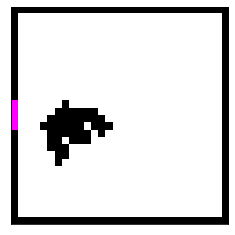

In [6]:
endtime = 100

# main function

# fill board with people and initialize them

board, person_list = init_board(board_size,num_people,exit_locs,sight_radius,state_dic,B_exit,B_wall)
initial_fall_locs = [[16, 4]]
initial_fall_loc = initial_fall_locs[np.random.randint(len(initial_fall_locs))]

# add starting board to stampede clip, this will later be transformed to a gif.

stampede_clip = np.zeros((0,board_size,board_size,3))
temp = np.reshape(plot_room(board,state_dic,B_exit,B_wall),(1,board_size,board_size,3))
stampede_clip = np.vstack((stampede_clip,temp))

time = 0
endtime = 100

stampede = True
chaos = False

S = init_S(board_size, S_wall, S_exit, obstacle_locs, exit_locs, mu)
D = init_D(board_size)
F = init_F(board_size)

while stampede and time <= endtime:
    print(time)

    if time == Ts:
        chaos = True
        c_list = np.random.choice(range(len(person_list)), size=(1), replace = False)
        for x in c_list:
            person_in_the_way = [person for person in person_list if person.location == initial_fall_loc]
            if len(person_in_the_way) > 0:
                person_in_the_way[0].location = person_list[x].location

            person_list[x].state = 'C'
            person_list[x].time_down = 0 
            person_list[x].direction = [2,2]
            person_list[x].location = initial_fall_loc
            person_list[x].new_location = person_list[x].location
            c_loc = person_list[x].location
            board[c_loc[0],c_loc[1]] = 2*state_dic['C']

        fallen_locs,board = update_board(board_size,person_list,state_dic,chaos,B_exit)
        F = update_F(board_size, fallen_locs, Srange)

    if time > Tc and chaos:
        chaos = False
        obstacle_locs[0] += list(fallen_locs[0])
        obstacle_locs[1] += list(fallen_locs[1])
        S = init_S(board_size, S_wall, S_exit, obstacle_locs, exit_locs, mu)

    # step 2: iterate over every person in person_list

    if time > 1 and len(prev_locations) > 0:
        D = update_D(D, locations, prev_locations, diffusion_factor, decay_factor)

    if time > 1 and not(np.array_equal(fallen_locs,prev_fallen_locs)) and len(fallen_locs[0]) > 0:
        # note that Fij is -inf if there is an obstacle/fallen person on Fij
        F = update_F(board_size, fallen_locs, Srange)

    prev_fallen_locs = fallen_locs
    prev_locations = get_locations(person_list)
    directionmap = get_directions(board_size,person_list)
    paired_fallen_locs = [[fallen_locs[0][i], fallen_locs[1][i]] for i in range(len(fallen_locs[0]))]

    for person in person_list:
        
        # calculate state of person
        person = check_state(person,exit_locs,fallen_locs,chaos)
        
        # if person has been evacuated, remove from person list

        if person.state == 'left':
            person_id = person_list == person
            person_list = np.delete(person_list, person_id)
            prev_locations = np.delete(prev_locations,person_id,axis=0)
            locations = np.delete(locations,person_id,axis=0)

        else:
            # calculate movement of each person 
            # or if person.state = 'C' calculate chance of getting up
            
            person, board = move_direction(person,person_list,board,S,D,F,exit_locs,fallen_locs,paired_fallen_locs,directionmap,sight_radius,board_size,ks,kd,kf,ka,kc,B_wall,B_exit,state_dic)
            fallen_locs, board = update_board(board_size,person_list,state_dic,chaos,B_exit)
            paired_fallen_locs = [[fallen_locs[0][i], fallen_locs[1][i]] for i in range(len(fallen_locs[0]))]
    
    next_locations = np.array([person.new_location for person in person_list if person.state != 'C'])
    next_loc_person_list = np.array([person for person in person_list if person.state != 'C'])

    # find duplicate locations in next_locations list and put in dupes

    dupes, count = np.unique(next_locations, axis=0, return_counts=True)
    non_dupes = dupes[count == 1]
    dupes = dupes[count > 1]
    if dupes.size > 0:

        for dupe in dupes:
            # for all dupes calc which person moves and set its location to new location
            # The other persons stay in their original location and thus don't need to be adjusted
            people_moving = next_loc_person_list[np.all(next_locations == dupe,axis=1)]
            np.random.shuffle(people_moving)
            picked = people_moving[0]
            picked.location = picked.new_location
            people_moving = people_moving[1:]
            
            for people in people_moving:
                if people.new_location in paired_fallen_locs:
                    people.new_location = people.location
                    person.state = "C"
                    person.time_down = 0
                    person.direction = [2,2]
                    board[person.location[0], person.location[1]] += 1
                    board[person.new_location[0], person.new_location[1]] += 1

        
        for non_dupe in non_dupes:
            # set location to new locations
            person_moving = next_loc_person_list[np.all(next_locations == non_dupe,axis=1)][0]
            person_moving.location = person_moving.new_location
    
    else:
        for person in next_loc_person_list:
            person.location = person.new_location

    locations = get_locations(person_list)

    # check if stampede is over

    stampede = check_stampede(person_list,chaos)

    # write current board to total
    temp = np.reshape(plot_room(board,state_dic,B_exit,B_wall),(1,board_size,board_size,3))
    stampede_clip = np.vstack((stampede_clip,temp))
        
    if time % 20 == 0:
        showboard = plot_room(board, state_dic, B_exit, B_wall)
        plt.imshow(showboard)
        plt.show()

    time += 1
print(f"The stampede lasted {time-1} seconds.")
make_gif(stampede_clip, filename = 'stampede_fig8')

# Recreate fig. 9

Now simulating for 100 pedestrians.
Simulation 0 ...
The stampede lasted 81 seconds.
Simulation 1 ...
The stampede lasted 44 seconds.
Simulation 2 ...
The stampede lasted 81 seconds.
Simulation 3 ...
The stampede lasted 44 seconds.
Simulation 4 ...
The stampede lasted 43 seconds.
Now simulating for 200 pedestrians.
Simulation 0 ...
The stampede lasted 110 seconds.
Simulation 1 ...
The stampede lasted 99 seconds.
Simulation 2 ...
The stampede lasted 109 seconds.
Simulation 3 ...
The stampede lasted 106 seconds.
Simulation 4 ...
The stampede lasted 87 seconds.
Now simulating for 300 pedestrians.
Simulation 0 ...
The stampede lasted 116 seconds.
Simulation 1 ...
The stampede lasted 200 seconds.
Simulation 2 ...
The stampede lasted 166 seconds.
Simulation 3 ...
The stampede lasted 116 seconds.
Simulation 4 ...
The stampede lasted 200 seconds.
Now simulating for 400 pedestrians.
Simulation 0 ...
The stampede lasted 200 seconds.
Simulation 1 ...
The stampede lasted 153 seconds.
Simulation 2 

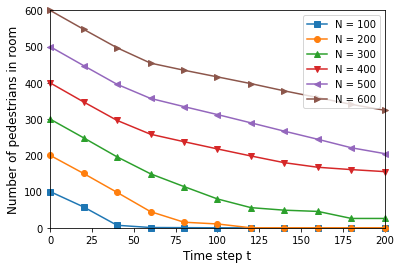

In [7]:
num_repeats = 5 # Increase for less impact from randomness (Figure in our report used 10 repeats, article used 30)
num_people_list = np.zeros((num_repeats, 6, 11))
repeat_counter = 0
range_counter = 0

Tc = Ts + 50 # chaos ending time
endtime = 200

for num_people in range(100, 601, 100):
    print("Now simulating for", num_people, "pedestrians.")
    for num_repeat in range(num_repeats):
        print("Simulation", num_repeat, "...")

        obstacle_locs = [[],[]]
        fallen_locs = [[],[]] # No obstacles for now        

        # main function

        # fill board with people and initialize them

        board, person_list = init_board(board_size,num_people,exit_locs,sight_radius,state_dic,B_exit,B_wall)
        initial_fall_locs = [[16, 4]]
        initial_fall_loc = initial_fall_locs[np.random.randint(len(initial_fall_locs))]

        time = 0

        stampede = True
        chaos = False

        S = init_S(board_size, S_wall, S_exit, obstacle_locs, exit_locs, mu)
        D = init_D(board_size)
        F = init_F(board_size)

        while stampede and time <= endtime:

            if time == Ts:
                chaos = True
                c_list = np.random.choice(range(len(person_list)), size=(1), replace = False)
                for x in c_list:
                    person_in_the_way = [person for person in person_list if person.location == initial_fall_loc]
                    if len(person_in_the_way) > 0:
                        person_in_the_way[0].location = person_list[x].location

                    person_list[x].state = 'C'
                    person_list[x].time_down = 0 
                    person_list[x].direction = [2,2]
                    person_list[x].location = initial_fall_loc
                    person_list[x].new_location = person_list[x].location
                    c_loc = person_list[x].location
                    board[c_loc[0],c_loc[1]] = 2*state_dic['C']

                fallen_locs,board = update_board(board_size,person_list,state_dic,chaos,B_exit)
                F = update_F(board_size, fallen_locs, Srange)

            if time > Tc and chaos:
                chaos = False
                obstacle_locs[0] += list(fallen_locs[0])
                obstacle_locs[1] += list(fallen_locs[1])
                S = init_S(board_size, S_wall, S_exit, obstacle_locs, exit_locs, mu)

            # step 2: iterate over every person in person_list

            if time > 1 and len(prev_locations) > 0:
                D = update_D(D, locations, prev_locations, diffusion_factor, decay_factor)

            if time > 1 and not(np.array_equal(fallen_locs,prev_fallen_locs)) and len(fallen_locs[0]) > 0:
                # note that Fij is -inf if there is an obstacle/fallen person on Fij
                F = update_F(board_size, fallen_locs, Srange)

            prev_fallen_locs = fallen_locs
            prev_locations = get_locations(person_list)
            directionmap = get_directions(board_size,person_list)
            paired_fallen_locs = [[fallen_locs[0][i], fallen_locs[1][i]] for i in range(len(fallen_locs[0]))]

            for person in person_list:
                
                # calculate state of person
                person = check_state(person,exit_locs,fallen_locs,chaos)
                
                # if person has been evacuated, remove from person list

                if person.state == 'left':
                    person_id = person_list == person
                    person_list = np.delete(person_list, person_id)
                    prev_locations = np.delete(prev_locations,person_id,axis=0)
                    locations = np.delete(locations,person_id,axis=0)

                else:
                    # calculate movement of each person 
                    # or if person.state = 'C' calculate chance of getting up
                    
                    person, board = move_direction(person,person_list,board,S,D,F,exit_locs,fallen_locs,paired_fallen_locs,directionmap,sight_radius,board_size,ks,kd,kf,ka,kc,B_wall,B_exit,state_dic)
                    fallen_locs, board = update_board(board_size,person_list,state_dic,chaos,B_exit)
                    paired_fallen_locs = [[fallen_locs[0][i], fallen_locs[1][i]] for i in range(len(fallen_locs[0]))]
            
            next_locations = np.array([person.new_location for person in person_list if person.state != 'C'])
            next_loc_person_list = np.array([person for person in person_list if person.state != 'C'])

            # find duplicate locations in next_locations list and put in dupes

            dupes, count = np.unique(next_locations, axis=0, return_counts=True)
            non_dupes = dupes[count == 1]
            dupes = dupes[count > 1]
            if dupes.size > 0:

                for dupe in dupes:
                    # for all dupes calc which person moves and set its location to new location
                    # The other persons stay in their original location and thus don't need to be adjusted
                    people_moving = next_loc_person_list[np.all(next_locations == dupe,axis=1)]
                    np.random.shuffle(people_moving)
                    picked = people_moving[0]
                    picked.location = picked.new_location
                    people_moving = people_moving[1:]
                    
                    for people in people_moving:
                        if people.new_location in paired_fallen_locs:
                            people.new_location = people.location
                            person.state = "C"
                            person.time_down = 0
                            person.direction = [2,2]
                            board[person.location[0], person.location[1]] += 1
                            board[person.new_location[0], person.new_location[1]] += 1

                
                for non_dupe in non_dupes:
                    # set location to new locations
                    person_moving = next_loc_person_list[np.all(next_locations == non_dupe,axis=1)][0]
                    person_moving.location = person_moving.new_location
            
            else:
                for person in next_loc_person_list:
                    person.location = person.new_location

            locations = get_locations(person_list)

            # check if stampede is over

            stampede = check_stampede(person_list,chaos)

            if time % 20 == 0:
                num_people_list[repeat_counter, range_counter, time//20] = len(person_list)

            time += 1
        print(f"The stampede lasted {time-1} seconds.")

        repeat_counter += 1

    repeat_counter = 0
    range_counter += 1


mean_num_people = np.mean(num_people_list, axis = 0)
t = np.arange(0, 201, 20)
labels = np.arange(100, 601, 100)
markers = ["s", "o", "^", "v", "<", ">"]

axs = plt.gca()
axs.set_xlim([0, 200])
axs.set_ylim([0, 600])
for i in range(mean_num_people.shape[0]):
    axs.plot(t, mean_num_people[i,:], label = "N = " + str(labels[i]), marker = markers[i], clip_on = False)
axs.legend(loc = "upper right")
axs.set_xlabel("Time step t", fontsize = "large")
axs.set_ylabel("Number of pedestrians in room", fontsize = "large")

plt.show()